# Read Me before running

This notebook was developed on CoLab, if you want to run it, please upload folder *data* and this notebook to Google Drive.

## Load Sparknlp


In [2]:
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

--2021-12-23 17:47:48--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://setup.johnsnowlabs.com/colab.sh [following]
--2021-12-23 17:47:49--  https://setup.johnsnowlabs.com/colab.sh
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2021-12-23 17:47:49--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:44

In [3]:
import sparknlp
from sparknlp.pretrained import PretrainedPipeline 
import time
from pyspark.sql.types import FloatType, ArrayType, MapType, StringType, IntegerType
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StandardScaler

spark = sparknlp.start()

print("Spark NLP version: {}".format(sparknlp.version()))
print("Apache Spark version: {}".format(spark.version))

Spark NLP version: 3.3.4
Apache Spark version: 3.0.3


In [44]:
#from sparknlp.pretrained import PretrainedPipeline 

In [3]:
pipeline = PretrainedPipeline('analyze_sentimentdl_glove_imdb', 'en')

analyze_sentimentdl_glove_imdb download started this may take some time.
Approx size to download 155.3 MB
[OK!]


In [4]:
result = pipeline.annotate("Harry Potter is a great movie.")

In [5]:
print(result['sentiment'])

['pos']


In [6]:
result

{'document': ['Harry Potter is a great movie.'],
 'sentence': ['Harry Potter is a great movie.'],
 'sentence_embeddings': ['Harry Potter is a great movie.'],
 'sentiment': ['pos'],
 'tokens': ['Harry', 'Potter', 'is', 'a', 'great', 'movie', '.'],
 'word_embeddings': ['Harry', 'Potter', 'is', 'a', 'great', 'movie', '.']}

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls /content/drive/MyDrive/data

all_comments.csv  NRC.xlsx


# Load data

In [6]:
#import time
#from pyspark.sql.types import FloatType, ArrayType, MapType, StringType, IntegerType
from pyspark.sql.functions import udf

df_comments = spark.read.option("header",True).csv("/content/drive/MyDrive/data/all_comments.csv")

def date_transfer(date):
    date = str(date)
    date_now = date[:4] + "-"+ date[4:6] + "-" + date[6:8] 
    monthstart = date[:4] + "-"+ date[4:6] + "-" + "01" 
    monthmid = date[:4] + "-"+ date[4:6] + "-" + "15" 
    s_date_now = time.mktime(time.strptime(date_now, '%Y-%m-%d'))
    s_monthstart = time.mktime(time.strptime(monthstart, '%Y-%m-%d'))
    s_monthmid = time.mktime(time.strptime(monthmid, '%Y-%m-%d'))

    if s_date_now - s_monthmid > 0:
        return monthmid
    elif s_date_now - s_monthmid <= 0:
        return monthstart
udf_date_transfer = udf(lambda z: date_transfer(z), StringType())

df_comments = df_comments.withColumn("date1", udf_date_transfer(df_comments.date)).drop("date")

df_comments.show()


+--------------------+----+----------+
|                text|from|     date1|
+--------------------+----+----------+
|Think about it th...| SUN|2020-03-15|
|&quot;Advice&quot...| SUN|2020-03-15|
|He sounds like a ...| SUN|2020-03-15|
|CANCEL COUNCIL TA...| SUN|2020-03-15|
|Then please solve...| SUN|2020-03-15|
|There&#39;s more ...| SUN|2020-03-15|
|Within a week we’...| SUN|2020-03-15|
|Over 70s, vulnera...| SUN|2020-03-15|
|It&#39;s selfish ...| SUN|2020-03-15|
|Boris needs to gr...| SUN|2020-03-15|
|This by the way t...| SUN|2020-03-15|
|I have anxiety so...| SUN|2020-03-15|
|Financial aid for...| SUN|2020-03-15|
|Nobody taking thi...| SUN|2020-03-15|
|I’ve just had to ...| SUN|2020-03-15|
|Don’t forget a fe...| SUN|2020-03-15|
|Well force a lock...| SUN|2020-03-15|
|Businesses can&#3...| SUN|2020-03-15|
|Nobody is taking ...| SUN|2020-03-15|
|Take the money fr...| SUN|2020-03-15|
+--------------------+----+----------+
only showing top 20 rows



# Semantic Level Sentiment Analysis 

In [7]:
def get_sentiment_p(text):
    
    if text[0][3] != 'neg':
        return 1.0
    else:
        return 0.0

def get_sentiment_n(text):
    
    if text[0][3] == 'neg':
        return 1.0
    else:
        return 0.0


udf_get_sentiment_p = udf(lambda z: get_sentiment_p(z), FloatType())
udf_get_sentiment_n = udf(lambda z: get_sentiment_n(z), FloatType())

all_comments  = df_comments
pipeline = PretrainedPipeline('analyze_sentimentdl_glove_imdb', 'en')
results = pipeline.transform(all_comments).select("from","date1","sentiment")
results = results.withColumn("pos", udf_get_sentiment_p(results.sentiment)) \
                  .withColumn("neg", udf_get_sentiment_n(results.sentiment)) \
                  .select("from","date1","pos","neg")

results = results.groupBy('from','date1') \
                .agg({"pos":"sum","neg":"sum"}) \
                .withColumnRenamed("sum(pos)", "pos") \
                .withColumnRenamed("sum(neg)", "neg") 

def Sentiment_score(x,y):
    return x-y

udf_Sentiment_score = udf(lambda x,y: Sentiment_score(x,y), FloatType())

results = results.withColumn("score", udf_Sentiment_score(results.pos, results.neg))

results.show()

analyze_sentimentdl_glove_imdb download started this may take some time.
Approx size to download 155.3 MB
[OK!]
+-----------+----------+----+----+-----+
|       from|     date1| neg| pos|score|
+-----------+----------+----+----+-----+
|Independent|2021-01-01|20.0|20.0|  0.0|
|   Guardian|2021-02-15|26.0|14.0|-12.0|
|        BBC|2020-06-15|56.0|24.0|-32.0|
|        SUN|2020-05-15|12.0| 8.0| -4.0|
|  DailyMail|2021-02-01|13.0| 7.0| -6.0|
|  DailyMail|2021-01-01|14.0| 6.0| -8.0|
|Independent|2020-10-01|30.0|10.0|-20.0|
|        BBC|2020-05-01|25.0|15.0|-10.0|
|        BBC|2020-05-15|27.0|13.0|-14.0|
|  DailyMail|2021-06-15|24.0|16.0| -8.0|
|        BBC|2020-09-15|42.0|18.0|-24.0|
|        BBC|2020-11-01|35.0|25.0|-10.0|
|   Guardian|2020-12-15|55.0|44.0|-11.0|
|   Guardian|2021-02-01|27.0|13.0|-14.0|
|        BBC|2020-04-15|54.0|26.0|-28.0|
|  DailyMail|2020-10-15|12.0| 7.0| -5.0|
|        SUN|2020-06-15|39.0|21.0|-18.0|
|Independent|2020-11-01|11.0| 9.0| -2.0|
|Independent|2020-05-15|24.

## MinMaxScaler

In [8]:
def get_score(x):
    return float(x)
udf_get_score = udf(lambda z: get_score(z[0]), FloatType())

all_scores = results
#all_scores = all_scores.withColumn("neg_scaled1", udf_get_score(all_scores.neg_scaled)) \
#                      .withColumn("pos_scaled1", udf_get_score(all_scores.pos_scaled)) \
#                      .select("from","date1","neg_scaled1","pos_scaled1")

#all_scores = all_scores.withColumn("score_scaled", udf_get_score(all_scores.score_scaled)) \
#                        .select("from","date1","score_scaled")

def date_mk(date):
    date = str(date)
    return time.mktime(time.strptime(date, '%Y-%m-%d'))

udf_date_mk = udf(lambda z: date_mk(z), FloatType())

SUN_final = all_scores.filter(all_scores['from'] == 'SUN').withColumn("date_mk", udf_date_mk(all_scores.date1)).sort('date_mk')
BBC_final = all_scores.filter(all_scores['from'] == 'BBC').withColumn("date_mk", udf_date_mk(all_scores.date1)).sort('date_mk')
DailyMail_final = all_scores.filter(all_scores['from'] == 'DailyMail').withColumn("date_mk", udf_date_mk(all_scores.date1)).sort('date_mk')
Independent_final = all_scores.filter(all_scores['from'] == 'Independent').withColumn("date_mk", udf_date_mk(all_scores.date1)).sort('date_mk')
Guardian_final = all_scores.filter(all_scores['from'] == 'Guardian').withColumn("date_mk", udf_date_mk(all_scores.date1)).sort('date_mk')

SUN_final.show()
BBC_final.show()
DailyMail_final.show()
Independent_final.show()
Guardian_final.show()


+----+----------+----+----+-----+-----------+
|from|     date1| neg| pos|score|    date_mk|
+----+----------+----+----+-----+-----------+
| SUN|2020-03-15|48.0|32.0|-16.0|1.5842304E9|
| SUN|2020-04-15|50.0|30.0|-20.0|1.5869088E9|
| SUN|2020-05-01|36.0|24.0|-12.0|1.5882912E9|
| SUN|2020-05-15|12.0| 8.0| -4.0|1.5895008E9|
| SUN|2020-06-01|14.0| 6.0| -8.0|1.5909696E9|
| SUN|2020-06-15|39.0|21.0|-18.0|1.5921792E9|
| SUN|2020-09-01|17.0| 3.0|-14.0|1.5989184E9|
| SUN|2020-09-15|42.0|18.0|-24.0| 1.600128E9|
| SUN|2020-10-01|10.0|10.0|  0.0|1.6015104E9|
| SUN|2020-10-15|38.0|22.0|-16.0|  1.60272E9|
| SUN|2020-11-01|15.0| 5.0|-10.0|1.6041888E9|
| SUN|2020-12-15|63.0|37.0|-26.0|1.6079904E9|
| SUN|2021-01-01|30.0|10.0|-20.0|1.6094592E9|
| SUN|2021-02-01|12.0| 8.0| -4.0|1.6121376E9|
| SUN|2021-02-15|38.0|22.0|-16.0|1.6133472E9|
| SUN|2021-03-01|15.0| 5.0|-10.0|1.6145568E9|
| SUN|2021-06-01|27.0|13.0|-14.0|1.6225056E9|
| SUN|2021-06-15|26.0|14.0|-12.0|1.6237152E9|
+----+----------+----+----+-----+-

# Visualization

In [9]:
all_media = [SUN_final,BBC_final,DailyMail_final,Independent_final,Guardian_final]

overall_media = results.groupBy("from").agg({"pos":"sum","neg":"sum"}) 

overall_media.show()

+-----------+--------+--------+
|       from|sum(neg)|sum(pos)|
+-----------+--------+--------+
|  DailyMail|   238.0|   100.0|
|   Guardian|   467.0|   272.0|
|        SUN|   532.0|   288.0|
|        BBC|   546.0|   314.0|
|Independent|   410.0|   228.0|
+-----------+--------+--------+



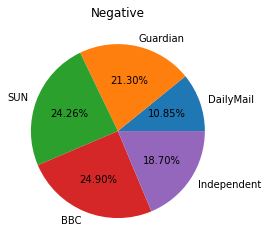

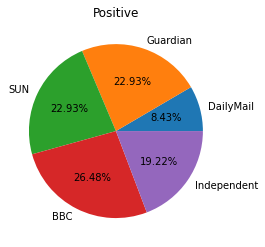

In [10]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
neg = np.array([238.0, 467.0, 532.0, 546.0, 410.0])
pos = np.array([100.0, 272.0, 272.0, 314.0, 228.0])
ax1 = plt.pie(neg,
        labels=['DailyMail','Guardian','SUN','BBC',"Independent"], 
        autopct='%.2f%%',
        #colors=["#d5695d", "#5d8ca8", "#65a479", "#a564c9"], 
       )

plt.title("Negative") 
plt.show()

ax1 = plt.pie(pos,
        labels=['DailyMail','Guardian','SUN','BBC',"Independent"],
        autopct='%.2f%%',
        #colors=["#d5695d", "#5d8ca8", "#65a479", "#a564c9"],
       )

plt.title("Positive")
plt.show()

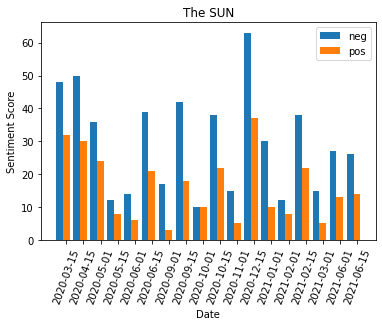

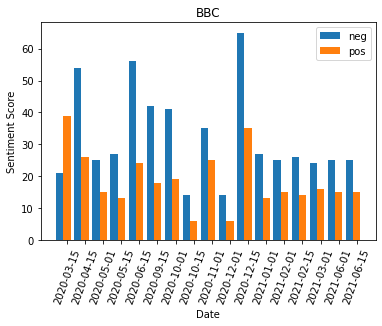

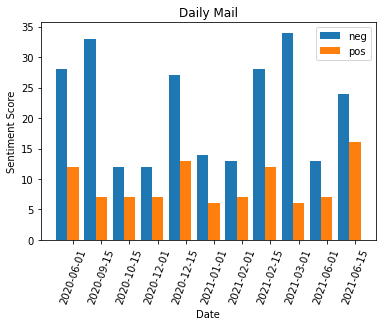

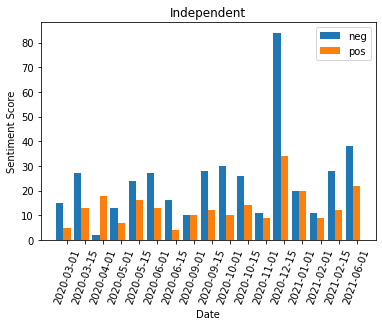

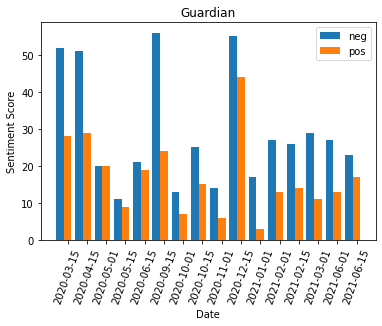

In [11]:
def get_value(media_df,Sentiment):
    Sentiment_list = media_df.select(Sentiment)
    Sentiment_list = [float(row[Sentiment]) for row in Sentiment_list.collect()]
    
    return Sentiment_list

def get_date(media_df):
    date_mk_list = media_df.select('date_mk')
    date_mk_list = [float(row['date_mk']) for row in date_mk_list.collect()]

    return date_mk_list


media_name = ["The SUN","BBC","Daily Mail","Independent","Guardian"]
m = 0
for media in all_media:

    size = 5
    total_width, n = 0.8, 2
    width = total_width / n
    x = list(range(len(get_value(media,'pos'))))


    date = [time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(i))[:10] for i in get_date(media)]

    plt.bar(x, get_value(media,'neg'),width=width, label='neg')
    for i in range(len(x)):
        x[i] = x[i] + width
    plt.bar(x, get_value(media,'pos'),width=width, tick_label = date, label='pos')
    
    plt.title(media_name[m])
    m = m+1
    plt.xlabel('Date')
    plt.ylabel('Sentiment Score')
    plt.legend()
    plt.xticks(rotation=70)
    plt.show()